# Overview
- bssidの可視化

In [5]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

cf1ce7c


# Const

In [6]:
NB = '015'
DIR_TRAIN = './../data_ignore/input/train/'
DIR_TEST = './../data_ignore/input/test/'
DIR_WIFI = './../data_ignore/input/wifi/'
PATH_SUB = './../data_ignore/input/sample_submission.csv'
PATH_99_SUB = './../data/input/floor_99per_acc_sub.csv'
DIR_SAVE_IGNORE = f'./../data_ignore/nb/{NB}/'
DIR_SAVE = f'./../data/nb/{NB}/'

# Import everything I need:)

In [7]:
import os
import time
import yaml
import json
import types
import random
import pickle
import builtins
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic
from ipdb import set_trace as st
import matplotlib.pyplot as plt
from dataclasses import dataclass
# from tqdm import tqdm
from fastprogress import progress_bar, master_bar
from glob import glob
from loguru import logger
from collections import OrderedDict
from lmfit import Parameters, Minimizer, report_fit


# Function

In [8]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )


def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [10]:
def trace_plot(site, floor):
    # trace
    path_trace_list = sorted(glob(f'./../data_ignore/input/train/{site}/{floor}/*'))

    # json
    path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # show image
    title = f'site: {site}\nfloor: {floor}'
    cmap = plt.get_cmap("tab20b")
    path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.patch.set_facecolor('white')
    fig.suptitle(title, fontsize=18)
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))

    for i_trace in range(len(path_trace_list)):
        data = read_data_file(path_trace_list[i_trace])
        waypoints = data.waypoint
        x_arr = waypoints[:, 1]
        y_arr = waypoints[:, 2]

        ax.plot(x_arr, y_arr, linewidth=2, alpha=0.5)
    return fig

In [11]:
def get_site_floor_fig(site, floor):
    # json
    path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    s = max(width_meter, height_meter)
    w = round(10*width_meter/s)
    h = round(10*height_meter/s)

    # show image
    cmap = plt.get_cmap("tab20b")
    path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
    fig, ax = plt.subplots(1, 1, figsize=(w, h))
    fig.patch.set_facecolor('white')
    title = f'site: {site}\nfloor: {floor}'
    fig.suptitle(title, fontsize=18)
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
    return fig, ax, width_meter, height_meter


def gaussian2D(x, y, height, cen_x, cen_y, sig):
    return height*np.exp(-(((cen_x-x)/sig)**2 + ((cen_y-y)/sig)**2)/2.0)


def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma = p["sig"].value
    return (z - gaussian2D(x,y,height,cen_x, cen_y, sigma))

# Preparation

<br>

set

In [12]:
pd.set_option('display.max_rows', 500)

if not os.path.exists(DIR_SAVE_IGNORE):
    os.makedirs(DIR_SAVE_IGNORE)
if not os.path.exists(DIR_SAVE):
    os.makedirs(DIR_SAVE)

<br>

load dataset

In [13]:
with open(f'{DIR_WIFI}train_all.pkl', 'rb') as f:
    df_train = pickle.load( f)
sample_submission = pd.read_csv(PATH_SUB)

In [19]:
df_list = []
for path in sorted(glob('./../data/nb/013/*.csv')):
    df_list.append(pd.read_csv(path))
df_wifi_pos = pd.concat(df_list, axis=0)

# EDA

In [22]:
df_train

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,rssi_95,rssi_96,rssi_97,rssi_98,rssi_99,x,y,floor,path,site_id
0,db01605eac3f33540038bd9722aba25774871d43,965f254a2e8d05bbb40bd2413ff61de3ad6c4151,0b64e537cc3d1818ec46f94f8dc14043a98d0089,922e582c66016a2b9f64e38f89ebe82f66eefb24,dc4c46287575c45f3e32c022d868d047b485ed4c,93e20595eeef175d3aa3c3381f6a22ee792d48d9,b2b0ddbb5a2aadfc6ab2f388db584b6c280d3f82,8c936564ea4b4300576f53136505527eb5972c07,61c3aaf1a526f808c05952ea3f098e37354a674a,3f564032c7eebc173b38aee35225e323d4389faf,...,-79,-79,-79,-79,-79,107.85044,161.892620,-1,5e1580adf4c3420006d520d4,5a0546857ecc773753327266
1,965f254a2e8d05bbb40bd2413ff61de3ad6c4151,db01605eac3f33540038bd9722aba25774871d43,1f37bbb3f42125f665b83584d0376b21ec3eb43c,922e582c66016a2b9f64e38f89ebe82f66eefb24,dc4c46287575c45f3e32c022d868d047b485ed4c,93e20595eeef175d3aa3c3381f6a22ee792d48d9,5c10b343d767a30515e6015de25751a2883328f8,3f564032c7eebc173b38aee35225e323d4389faf,46c934893439700099d03a6892ea934ecb2729d6,16374260af7d03b10f167358a4f6a70620e131f4,...,-79,-79,-79,-80,-80,107.85044,161.892620,-1,5e1580adf4c3420006d520d4,5a0546857ecc773753327266
2,965f254a2e8d05bbb40bd2413ff61de3ad6c4151,db01605eac3f33540038bd9722aba25774871d43,dc4c46287575c45f3e32c022d868d047b485ed4c,922e582c66016a2b9f64e38f89ebe82f66eefb24,93e20595eeef175d3aa3c3381f6a22ee792d48d9,61c3aaf1a526f808c05952ea3f098e37354a674a,ce28608c3d091ac0d25d84459ebad253edf83e1f,1bb0e992cff45a54d29e97f47a7d1281435a5e3b,1f37bbb3f42125f665b83584d0376b21ec3eb43c,ca86c5b074c5768e481e069b751bf22c6d95bd48,...,-77,-78,-78,-78,-78,98.33065,163.343340,-1,5e1580adf4c3420006d520d4,5a0546857ecc773753327266
3,61c3aaf1a526f808c05952ea3f098e37354a674a,922e582c66016a2b9f64e38f89ebe82f66eefb24,93e20595eeef175d3aa3c3381f6a22ee792d48d9,db01605eac3f33540038bd9722aba25774871d43,965f254a2e8d05bbb40bd2413ff61de3ad6c4151,0f5daed11a61e0d6941a1a42ff428ca216d61003,ce28608c3d091ac0d25d84459ebad253edf83e1f,40d99a3e5214aa704f637b7d72631e69550ee256,2aa08d092d0199c06d22684642ef1c79d9722adb,149c09a117b9851201c75f97b4a7cc94b75fdcb4,...,-75,-76,-76,-77,-77,98.33065,163.343340,-1,5e1580adf4c3420006d520d4,5a0546857ecc773753327266
4,965f254a2e8d05bbb40bd2413ff61de3ad6c4151,93e20595eeef175d3aa3c3381f6a22ee792d48d9,61c3aaf1a526f808c05952ea3f098e37354a674a,51782c2fabefa97e99dca895fd36f1a47e214610,db01605eac3f33540038bd9722aba25774871d43,0f5daed11a61e0d6941a1a42ff428ca216d61003,ce28608c3d091ac0d25d84459ebad253edf83e1f,4c83a7a1e51bfa8a5fa20e854ab3feec057c52c9,599fa96d549ed870671d6bc1927aaa8bbaacca12,dc9fd0f591e9bfc22748106f31d72a23c1d294fd,...,-75,-76,-76,-77,-77,98.33065,163.343340,-1,5e1580adf4c3420006d520d4,5a0546857ecc773753327266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,930dfcc059cd5c29f94b37435b31b14adf6141c1,3c79d9efcdb4c5803ab1b97982c2f0b87519c477,4472ce0cc1af0641cdffd6cdc850e9dd2ec4ab91,5953d0b2247e16447d327eb2a8a9c1abe24ff425,d2aa98dcefa4d46c4a946d26c5311bddddad9d6c,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,040bfca8631c5506cba1c22cf7750636ba26ea54,7fcc50af42706af2d8ecfe55b7ccbb731aae6e27,b719d7de6ffe1b1b7409d2eb5ac3268e36cf2675,89395d0ee75307b3beb30aef2f19fc680095d514,...,-84,-85,-85,-85,-85,122.68994,124.028015,6,5dcd5c88a4dbe7000630b084,5dc8cea7659e181adb076a3f
258121,930dfcc059cd5c29f94b37435b31b14adf6141c1,4472ce0cc1af0641cdffd6cdc850e9dd2ec4ab91,5953d0b2247e16447d327eb2a8a9c1abe24ff425,040bfca8631c5506cba1c22cf7750636ba26ea54,d2aa98dcefa4d46c4a946d26c5311bddddad9d6c,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,7e5f2b71ff184401c1c31ffeab2861d86f1f9c25,8bed40c61bc42247c3b142f214f78dcc5850553f,f9100b425367a18de9f1cec34a34ea60cc7bf009,3c79d9efcdb4c5803ab1b97982c2f0b87519c477,...,-85,-85,-85,-85,-85,127.17589,123.677780,6,5dcd5c88a4dbe7000630b084,5dc8cea7659e181adb076a3f
258122,040bfca8631c5506cba1c22cf7750636ba26ea54,930dfcc059cd5c29f94b37435b31b14adf6141c1,3c79d9efcdb4c5803ab1b97982c2f0b87519c477,4472ce0cc1af0641cdffd6cdc850e9dd2ec4ab91,5953d0b2247e16447d

In [25]:
df_train.iloc[:5, 100:200]

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,rssi_90,rssi_91,rssi_92,rssi_93,rssi_94,rssi_95,rssi_96,rssi_97,rssi_98,rssi_99
0,-32,-39,-47,-48,-48,-49,-51,-52,-54,-56,...,-79,-79,-79,-79,-79,-79,-79,-79,-79,-79
1,-29,-34,-47,-48,-48,-49,-52,-52,-52,-53,...,-79,-79,-79,-79,-79,-79,-79,-79,-80,-80
2,-33,-39,-48,-48,-49,-52,-54,-55,-55,-55,...,-77,-77,-77,-77,-77,-77,-78,-78,-78,-78
3,-46,-48,-49,-50,-51,-52,-54,-56,-57,-57,...,-75,-75,-75,-75,-75,-75,-76,-76,-77,-77
4,-42,-49,-51,-51,-52,-53,-54,-55,-55,-55,...,-75,-75,-75,-75,-75,-75,-76,-76,-77,-77


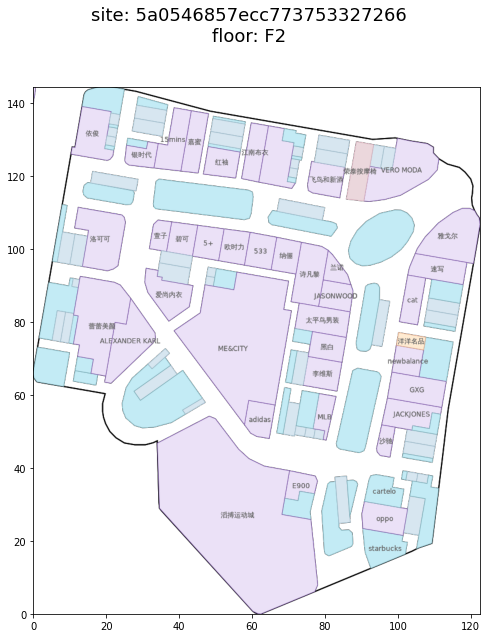

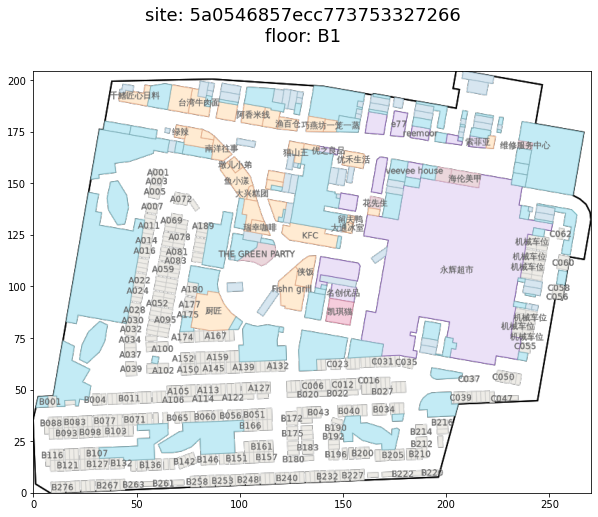

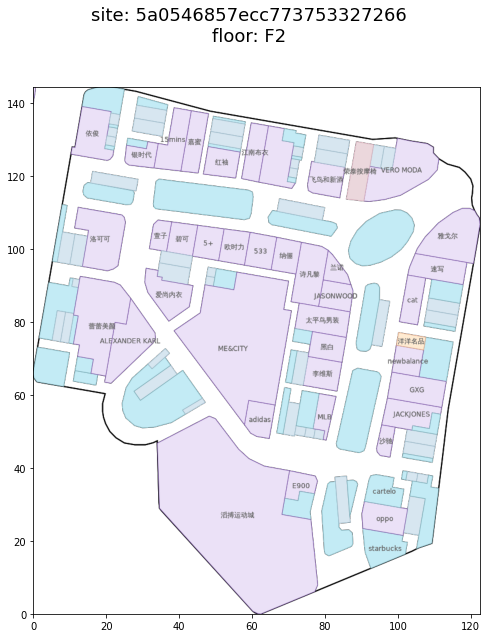

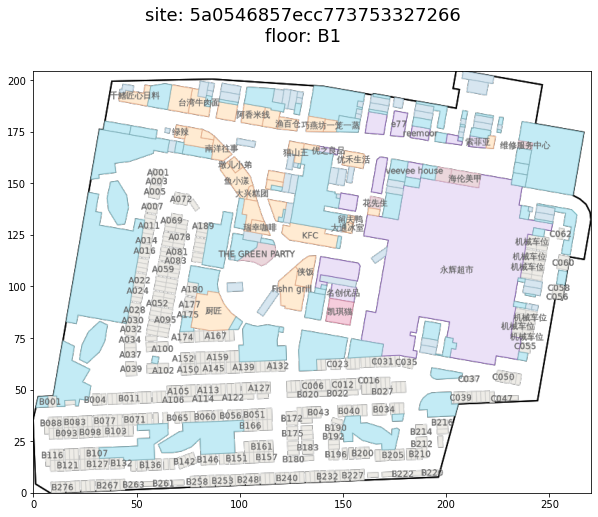

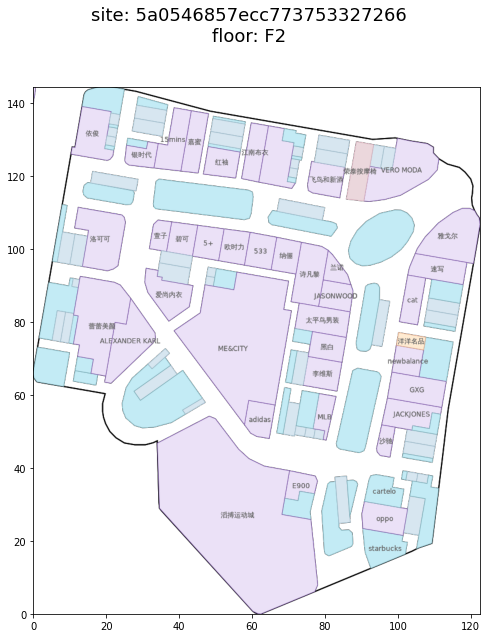

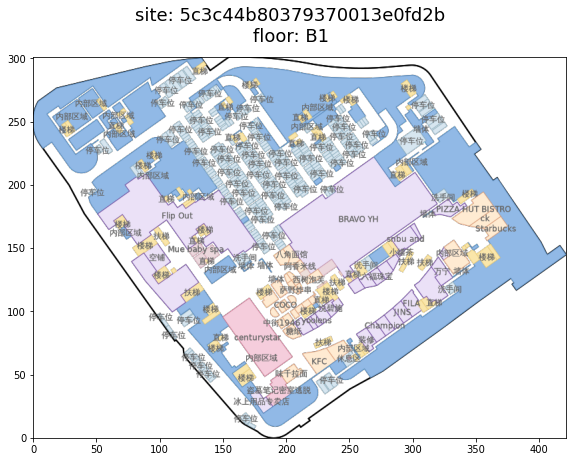

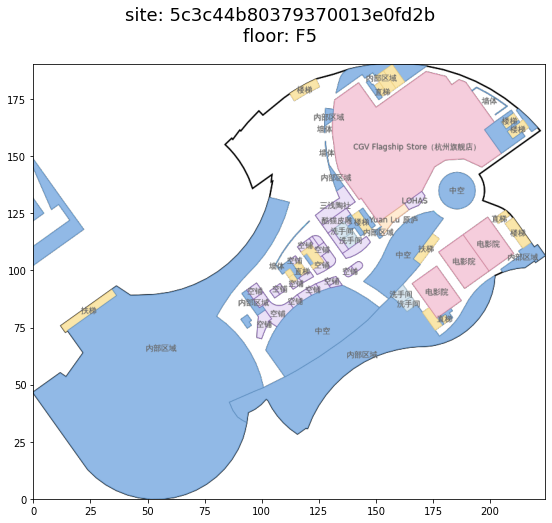

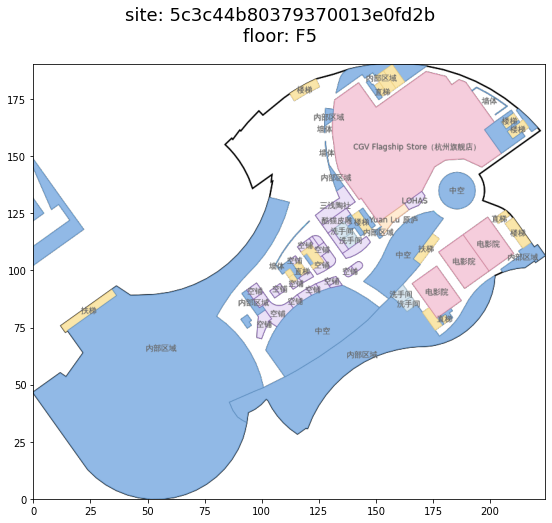

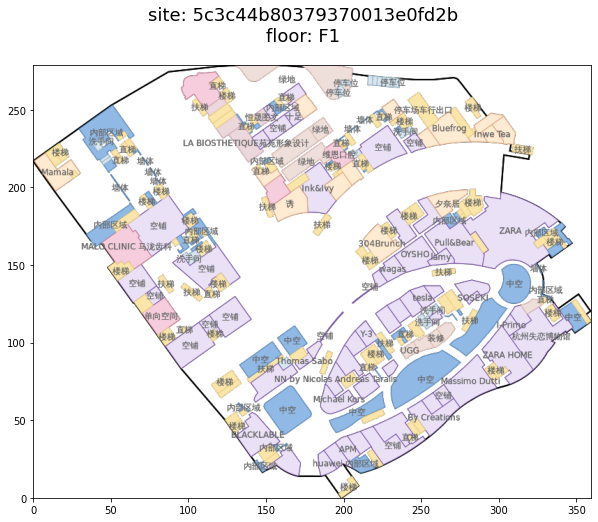

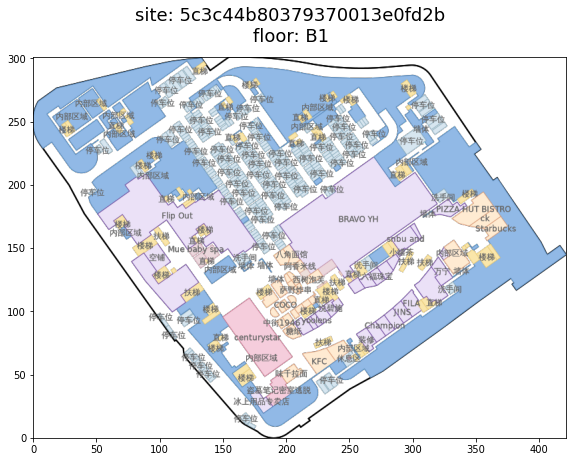

KeyboardInterrupt: 

In [21]:
%%time
# site
site_list = [val.split('_')[0] for val in sample_submission.site_path_timestamp]
site_list = sorted(np.unique(site_list).tolist())

for site in progress_bar(site_list):
    # dataのロード
    path_waypoint = f'./../data_ignore/nb/010/nb010_waypoint_{site}.csv'
    df_wp_ori = pd.read_csv(path_waypoint)

    path_wifi = f'./../data_ignore/nb/004/nb004_wifi_{site}.csv'
    df_wifi_ori = pd.read_csv(path_wifi)
    
    # floorのリストの取得
    floor_list = sorted(glob(f'./../data_ignore/input/train/{site}/*'))
    floor_list = [text.split('/')[-1] for text in floor_list]
    
    # floorをrandomに2つ選ぶ
    floor_choices = np.random.choice(floor_list, 5)
    
    # 決まったfloorとsiteで以下の処理を行う
    for floor in floor_choices:
        df_wp = df_wp_ori.query('floor == @floor')
        df_wifi = df_wifi_ori.query('floor == @floor')
        
        # ssidをランダムに選ぶ
        ssid = np.random.choice(df_wifi['ssid '].unique())
        df_wifi_ssid = df_wifi[df_wifi['ssid '] == ssid]

        # bssidをランダムに選ぶ
        bssid = np.random.choice(df_wifi_ssid['bssid'].unique())
        df_wifi_ssid_bssid = df_wifi_ssid.query('bssid == @bssid')
        
        # site, floor, ssid, bssidが決まった！
        # 以下でフィッティングと描画を行う
        fig, ax, width_meter, height_meter = get_site_floor_fig(site, floor)
        plt.pause(0.05)
        fig.show()